### **About this document**
##### **Module Name:** Data Science for Spatial Systems (CASA0006)
##### **Student ID:** ucfnxz0
##### **Title:** Patent Analysis for China's Epidemic Prevention Products
***

## **Patent Analysis for China's Epidemic Prevention Products**
<p style="color:DimGray; text-align:left; font-size:18px"><i> Based on clustering method and machine learning  </i></p>
<a id="ID_title"></a>

<p style="color:DimGray; text-align:left;"><i>This paper explores the predictive traits of patents of Epidemic Prevention Products (EPP) and looks deep into the multi-level distribution pattern of technologies used in patents. <br> The results show that an agglomeration in the types of patent technologies owned by cities has emerged. The predictive model built by China's EPP dataset could be used to detect other relevant patents.</i></p>

## 1.0 | Introduction

This paper contains these parts: data gathering, methods used in this document, data processing and results. Using open data (the patent dataset of epidemic prevention products) from China Patent Information Center, this paper tries to complete the following tasks: 

    (1) find the aggregation of technologies' types at the city or province level; 
    (2) build a predictive model for future detection of EPP relevant patents.

For helping users better understanding the analysis, this paper keeps the explanations, such as the introduction of various methods, the comments of processing procedures, as supplements.

***

### 1.1 | The Requirements of Environment to Run the Analysis

**Some external packages could be installed from below pip codes.**<br>
pip install google-cloud-bigquery<br>
pip install --upgrade google-api-python-client<br>
pip3 install --upgrade oauth2client<br>
pip install pandas-gbq -U<br>
pip install yellowbrick<br>

The external packages need to be used in this notebook: bigquery, GoogleCredentials.<br>

**NOTE: After unzipping the zip file, please keep the json file in the same direction as this notebook.**

In [1]:
%matplotlib inline
#import some stuffs
from google.cloud import bigquery
from oauth2client.client import GoogleCredentials
from googleapiclient import discovery
from IPython.display import display, HTML

Here below is the credential used for asking Google Cloud service.

In [2]:
import os
from google.cloud.bigquery.client import Client
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = './patent-309912-a7496452b092.json'

The package used for machine learning.

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics,datasets,manifold
from sklearn.model_selection import validation_curve
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import intercluster_distance
import sklearn.cluster as sk_cluster 

import joblib

Some common packages.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from scipy import optimize
import collections
from collections import Counter

***

## 2.0 | Literature Review

**Previous Studies**<br>

Since Schumpeter put forward that "innovation is the source of economic growth", the relationships among technologies, economic factors and innovation progress have received unprecedented attention in the academic area. Economic geographers have conducted a large number of studies on technological diffusion and innovation clustering. Some research paradigms have been proposed, such as the environment of innovation proposed by GREMI (Aydalot and Keeble, 1988), new industrial district (Granovetter, 1985; AMIN and THRIFT, 1992), industrial cluster and innovation cluster (Das,1998), national innovation system(Cooke, 1992; Georghiou, 1993), etc. In previous studies, the core point scholars proposed that innovation activities have prominent spatial agglomeration trait(Feldman,1994).To Understand the factors and mechanism that influence the agglomeration of innovation activities, scholars used R&D, patent, number of newly formed companies in the specific industry and their geographical distribution, number of the published papers, and other types of data to measure the input and output of innovation.

In recent years, scholars tried to classify different types of industries based on knowledge. Asheim et al. (Asheim, Coenen and Vang, 2007) divided industries into three types: science-based, engineering-based, and art-based industry. Plum et al. discussed the difference in knowledge network characteristics between the two knowledge bases: the analytical knowledge base and synthetic knowledge(Plum and Hassink, 2011). These classifications improve the accuracy of innovation research. Some scholars also studied innovation performance in the specific industry. Taking the pharmaceutical industry as an example, they found that functional proximity is more important to the innovation of the biomedical industry than geographical proximity(Coenen, Moodysson and Asheim, 2004). However, other scholars believe that the interactions among localized organizations are the internal mechanism of cluster innovation(Bagchi-Sen, Smith and Hall, 2004).


For patents analysis, it has been regarded as an effective method to detect the level of innovation in one region. Patent documents could reflect the embedded technologies the inventors use and the usage rights they claim. (Park, Yoon and Lee, 2005) Due to the invention of ‘cutting-edge’ technologies, researchers applied various new methods, such as networks, machine learning, artificial intelligence, modelling for spatial interaction, to discover the knowledge of patents. The results from the patent analysis could be used for detecting the emerging technologies, their clusters and trends, which could be evidence for governments to undertake policies for promoting innovation.


**Data** <br>

This EPP dataset contains 4150 records at the end of February 2020. The first EPP patent was recorded in 1995. It contains information such as name, city/province/country, publication number, abstract, IPC number, disclosure date, applicants, and enterprise's exact address. 

In terms of patent classification structure, each patent is classified by one or more IPC numbers. IPC number stands for International Patent Classification. It is administrated by WIPO (Worldwide Intellectual Property Office). The structure of the complete IPC number contains five levels, which are level I-V. Taking **C07H19/00** as an example, the first character ‘**C**’ belongs to level I, which means that the patent belongs to chemistry and metallurgy. **C07** belongs to level II, which refers to organic chemistry. **C07H** belongs to level III, referring to ‘sugars; derivatives thereof; nucleosides; nucleic acid’. **C07H19/00** belongs to level IV, and it refers to ‘compounds containing a hetero ring sharing one ring hetero atom with a saccharide radical; Nucleosides; Mononucleotides; Anhydro derivatives thereof’. This patent number does not refer to level V, which is more detailed.

Some papers regarded IPC classification as technologies used in patents. Jun et al. (Jun, Park and Jang, 2012) defined promising technologies by using association rule mining of IPC for the patent document. Shih et al. (Shih, Liu and Hsu, 2010) changed the parameters of patents in each simulation step to identify the promising technologies. This paper takes the same definition of using IPC as the patent's technology. 

Also, level III of the IPC number (such as C07H) could be more detailed than the previous two levels. It could reflect general technologies features used in a patent. On the other hand, it could be regarded as the category of level IV or V, convenient for researchers to group the similarities among patents' technologies. This paper chooses level III of IPC number to find the similarities among technologies in the cities， which will benefit searching technologies clusters.

**Research Questions**<br>

According to the tasks proposed in the introduction part, these research questions could lead to further investigations:

    RQ1 | How do China's cities cluster when considering various types of EPP patent technologies they own?
    RQ2 | How could an EPP patent prediction model be built by using Machine Learning on patent documents? How accurate is this model's prediction?
    

Finally, as the source data is available across city and province level, this paper also focuses on:
    
    RQ3 | Is there any clustering difference when two types of space scale are implemented?
    

***

## 3.0 | Methodology

**Method**<br>

The main methods used in this paper could be categorized into two parts:<br>

**Machine learning method group** is a method group that mainly contains supervised trait here. The training and test datasets are needed in the process of training, validating and testing the model. Each EPP patent instance in the training set will be labelled to 1 (Here, we could regard it as the symbol of 'ground truths'), which means that this patent belongs to the EPP dataset. The other patents belong to group 0, meaning that they are not included in the EPP dataset. This classification could help the machine learn the traits of classifying the unknown dataset to the EPP dataset. 

The methods used for training the model are: **TF-IDF**, **SGDClassifier( )**. 

    TF-IDF calculates two variables: one is the frequency of a word in a document; another one is the frequency of a word in the whole document set. TF-IDF could tell use how relevant a word is to a specific document in the whole documents dataset. 

    SGDClassifier is a linear classifier optimized by SGD (Stochastic Gradient Descent). SGD could make the process more efficient. It is common to combine TF-IDF with SGDClassifier to process the text documents.

**Clustering method group** is an unsupervised method group in comparison. For example, the machine does not need to understand the 'ground truths' before separating the sample into k groups when using **K-Means**. However, K-Means requires the numbers of clusters (k) as the input. Thus, determining and validating the k are the core issues to be done. Various papers have used this method to detect technology clusters in a patent dataset, such as Jun (Jun, 2016) and Kim (Kim and Bae, 2017). Both of them used Multidimensional Reduction and K-Means clustering to identify the technology clusters for predicting.

The main methods used for clustering in this paper are: **MDS**, **tests for k value**. 

    MDS (multidimensional reduction) is used for reducing the dimensions of the documents. It uses the distance matrix of instances in the original document as the input, calculating double centring, selecting n largest eigenvalues and corresponding eigenvectors, and multiplying the diagonal matrix of the n largest eigenvalues with the matrix of n eigenvectors. Usually, n is assigned to 2 for 2-D visualisation.

    As for the k value tests, this paper will use distortion and silhouette to test, and the elbow value and its score will determine the k.

In the below sections, the paper will be carried out by doing these procedures: gathering the data we need, cleaning and preprocessing the data to fit the structure the algorithms need, analysing the data and displaying the results.


***

## 4.0 | Data Gathering

The original dataset was separated into three parts based on its columns. All the datasets contain the same records as the original dataset. Here we use these  datasets as our input.

In [5]:
df_training_set = pd.read_csv('https://raw.githubusercontent.com/xudong-zh/DSSS-Final-Project/main/data/training_set.csv') 
df_clustering_raw = pd.read_csv('https://raw.githubusercontent.com/xudong-zh/DSSS-Final-Project/main/data/cluster_sample_ipc.csv')
df_region = pd.read_csv('https://raw.githubusercontent.com/xudong-zh/DSSS-Final-Project/main/data/region.csv')

**Main Variable Descriptions**

- **Publication number**: the unique id of one patent authorized by relevant agency.
- **Abstract**: descriptions of function of patent
- **Disclosure Date**: the date patent published
- **IPC**: International Patent Classification, it shows the technologies used in one patent.This is defined by WIPO (Worldwide Intellectual Property Office). Each patent may contain one or more IPC number.
- **Countries/provinces/cities**: the location of company which applicants belong to.
- **Patent citation**: the patents'  that were cited
- **Current statues**: valid or invalid information.This shows whether the technologies this patent claims are under protection of Intellectual Property law or not.
- **Type of patent**: invention, utility, appearance design.
- **Applicants**: most of them are organisation,company, university.
- **Inventors**: those who have made contributions to corresponding patents.
- **Main Classification**: the main IPC labelled to the patent which could reflect the main technology used in the patent, such as C07D309/10.
- **A61K,A61P ...**: specific technologies' category defined by WIPO. They are parts of IPC numbers and they could refect the technologies contents at level III. Notice that, if we regard the complete IPC number as specific technologies, the level III number could be criteria of classification. In 'cluster_sample_ipc.csv' file, the the number 1 in each relevant column means that the patent is included in this type of technology.

#### 4.1 | Data Used for Dectecting EPP Patents.

In [6]:
#change the format of the publication number from US1234567B2 to US-1234567-B2 to match the format in the database
df_training_set['Publication_Number'] = df_training_set['Publication_Number'].str.replace(r"(\D*)(\d*)(\D\d?)", "\\1-\\2-\\3")

In [7]:
#show the training set to see what it looks like.  Make sure it imported correctly.
df_training_set.drop_duplicates(['Publication_Number'], inplace=True)
df_training_set.head()

,Publication_Number,Label
0,CN-103052631-A,1
1,CN-105343098-A,1
2,CN-108348526-A,1
3,CN-107073005-A,1
4,CN-106573954-A,1


In [8]:
#load the dataset to Google BigQuery 

PROJECT_ID = 'patent-309912' # this project ID
DEST_DATASET = 'my_new_dataset'
samples_table = 'training_patents'

# Create a python client 
client = bigquery.Client(project=PROJECT_ID)

# Create an HTTP client for additional functionality.
credentials = GoogleCredentials.get_application_default()
http_client = discovery.build('bigquery', 'v2', credentials=credentials)

#attach to the dataset
dataset = client.dataset(DEST_DATASET)

#create the table 
full_table_path = '{}.{}'.format(DEST_DATASET, samples_table)
df_training_set.to_gbq(destination_table=full_table_path,
          project_id=PROJECT_ID,
          if_exists='replace')

1it [00:04,  4.37s/it]


We will use the title, abstract, and IPC codes combined into one text block to feed into the machine learning code for our training data.

In [9]:
#Create our query string. 
query = """
select pubs.publication_number, Label,
  CONCAT(
    IFNULL(
     (SELECT text from UNNEST(pubs.title_localized)LIMIT 1), " "), " ",
    IFNULL(
     (SELECT text from UNNEST(pubs.abstract_localized) LIMIT 1), " "), " ",
    IFNULL(
     ARRAY_TO_STRING( ARRAY(SELECT code from UNNEST(pubs.ipc)LIMIT 1), " "), " " ), " ",
    IFNULL(
     ARRAY_TO_STRING( ARRAY(SELECT REGEXP_REPLACE( code, "/.*", "") from UNNEST(pubs.ipc)LIMIT 1), " "), " ")) as text
from
  `patents-public-data.patents.publications` as pubs, UNNEST(title_localized) as title
  JOIN `""" + full_table_path + """` as input
  on pubs.publication_number = input.publication_number  
where (SELECT language from UNNEST(pubs.title_localized) LIMIT 1) = 'en' and
(SELECT language from UNNEST(pubs.abstract_localized) LIMIT 1) = 'en'
"""
df_training_set_finished = pd.read_gbq(query, project_id=PROJECT_ID, dialect='standard')
df_training_set_finished.drop_duplicates(['publication_number'], inplace=True)

#check to make sure we got back a dataset that looks right.
print("Shape:", df_training_set_finished.shape)

Shape: (1582, 3)


In [10]:
df_training_set_finished.head()

,publication_number,Label,text
0,US-8375302-B2,0,Example based video editing Enabling creation ...
1,US-7644414-B2,0,Application program interface for network soft...
2,US-7676461-B2,0,Implementation of stream algebra over class in...
3,US-7693817-B2,0,"Sensing, storing, indexing, and retrieving dat..."
4,US-7661088-B2,0,Systems and methods to efficiently and automat...


#### 4.2 | Data Used for Clustering Cities

In [11]:
df_clustering_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4157 entries, 0 to 4156
Columns: 171 entries, id to A23C
dtypes: float64(1), int64(167), object(3)
memory usage: 5.4+ MB


In [12]:
df_clustering_raw.head()

,id,city,country/province/city,IPC,A61K,A61P,C07H,C07F,C07D,C07C,...,H02M,F17C,H01B,G01G,H05B,C08K,C08G,C09K,C09J,A23C
0,1.0,California,US,C07D309/10;C07H19/00,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,California,US,A61K31/53;A61K31/675;A61P31/14;A61P31/16;C07D4...,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3.0,California,US,A61K31/53;A61K31/664;A61K31/683;A61K31/675;A61...,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,California,US,A61K31/53;A61K31/675;A61K31/685;C07F9/6561;C07...,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5.0,California,US,C07H19/073;C07H19/06;C07H19/10;A61K31/7072;A61...,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### **Shape** 
- an inconsistency appears at the end rows of this dataset.
- some cities/provinces not in China appear in the dataset, such as California.

In [13]:
df_clustering_raw=df_clustering_raw[:-2]

In [14]:
df_clustering_raw['country/province/city'] # We could notice that the dataset also contains patents that non-China enterprises own.

0              US
1              US
2              US
3              US
4              US
          ...    
4150     Shanghai
4151    Chongqing
4152      Jiangsu
4153     Shanghai
4154     Shanghai
Name: country/province/city, Length: 4155, dtype: object

**Here, we notice that the other countries' names are 2-digits abbreviations. We could use this trait to define the cities belong to other countries.**

In [15]:
countrycity_len=pd.DataFrame()

# Calculate the number of characters of cities' name.
countrycity_len['count'] = df_clustering_raw['country/province/city'].str.len()

# Combine the length of cities/countries data with clustering raw data
df_clustering=pd.concat([df_clustering_raw, countrycity_len], axis=1)

df_clustering.drop(df_clustering[df_clustering['count'] == 2].index.values, axis=0, inplace= True)
print(f"df_clustering now contains {df_clustering.shape[0]} rows.")

df_clustering=df_clustering.reset_index()

df_clustering now contains 3466 rows.


In [16]:
df_clustering.head()

,index,id,city,country/province/city,IPC,A61K,A61P,C07H,C07F,C07D,...,F17C,H01B,G01G,H05B,C08K,C08G,C09K,C09J,A23C,count
0,11,12.0,Beijing,Beijing,A61K31/715;A61K31/7024;A61K31/353;A61P31/12,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1,20,21.0,Suzhou,Jiangsu,A61K31/4045;A61K9/08;A61P31/16;C07D209/42,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,7
2,21,22.0,Suzhou,Jiangsu,C07D207/22;A61K31/4045;A61P39/00,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,7
3,22,23.0,Shijiazhuang,Hebei,A61K31/405;A61P31/14;A61P11/00,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,5
4,23,24.0,Shijiazhuang,Hebei,A61K31/405;A61P31/12;A61P31/18,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,5


##### **Columns**

The **IPC, index, id, count** columns are not what we want in the below analysing.

In [17]:
df_clustering.columns

Index(['index', 'id', 'city', 'country/province/city', 'IPC', 'A61K', 'A61P',
       'C07H', 'C07F', 'C07D',
       ...
       'F17C', 'H01B', 'G01G', 'H05B', 'C08K', 'C08G', 'C09K', 'C09J', 'A23C',
       'count'],
      dtype='object', length=173)

In [18]:
# Drop the columns we don't need in this analysis.
drop_col=['IPC','index','id','count']

for index, entry in enumerate(drop_col):
    df_clustering=df_clustering.drop(drop_col[index], axis=1)

# Classify the dataset by droping different spatial level.
df_clustering_city_raw=df_clustering.drop('country/province/city', axis=1)
df_clustering_province_raw=df_clustering.drop('city', axis=1)

df_clustering_city_raw.head()

,city,A61K,A61P,C07H,C07F,C07D,C07C,C07K,C07B,C12Q,...,H02M,F17C,H01B,G01G,H05B,C08K,C08G,C09K,C09J,A23C
0,Beijing,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Suzhou,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Suzhou,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Shijiazhuang,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Shijiazhuang,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**The dataset used for clustering still contains the duplicated cities. Because the dataset is still about the records of patents. Next step, we need to group them to city or province level.**

***

## 5.0 | Data Preprocessing and Descriptive Statistics

This paper focuses on cluster cities based on the categories of technologies they owned. The total number of technologies will not be used. 

Also, the number of patents registered in each city or province could reflect the level of knowledge reserves. And it is shown in the below histogram graph (5.2 section).

#### 5.1 | Group the data

In [19]:
def clusterdatapreparation(data,col):
    data=data.groupby(by = col).sum()
    data[data > 0] = 1 # All the data will be transformed to zero or one to interpret whether the city contains the technologies in these IPC categories (A61K，for example) or not.
    return data

In [20]:
df_clustering_city=clusterdatapreparation(df_clustering_city_raw,"city")
df_clustering_province=clusterdatapreparation(df_clustering_province_raw,"country/province/city")

In [21]:
df_clustering_city.head()

,A61K,A61P,C07H,C07F,C07D,C07C,C07K,C07B,C12Q,A61Q,...,H02M,F17C,H01B,G01G,H05B,C08K,C08G,C09K,C09J,A23C
city,,,,,,,,,,,,,,,,,,,,,
Aba,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Akesu,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Anguo,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ankang,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Anshan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
df_clustering_province.head()

,A61K,A61P,C07H,C07F,C07D,C07C,C07K,C07B,C12Q,A61Q,...,H02M,F17C,H01B,G01G,H05B,C08K,C08G,C09K,C09J,A23C
country/province/city,,,,,,,,,,,,,,,,,,,,,
Anhui,1,1,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
Beijing,1,1,1,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Chongqing,1,1,0,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Fujian,1,1,1,0,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
Gansu,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


**Here the sum of specific technologies' category in each city or province is calculated and displayed in the histogram.**

The graph shows that the majority of cities own 2-4 specific technologies' categories.

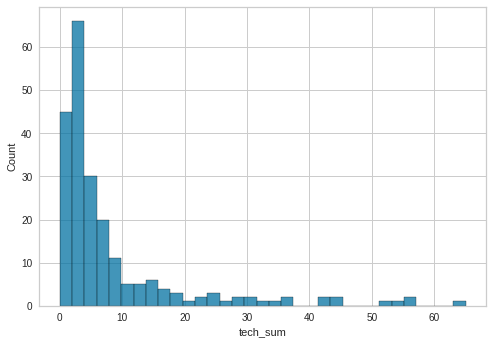

In [23]:
sum_city=pd.DataFrame()
sum_city["tech_sum"] = df_clustering_city.sum(axis=1)
ax=sns.histplot(data=sum_city, x="tech_sum")

<AxesSubplot:xlabel='tech_sum', ylabel='Count'>

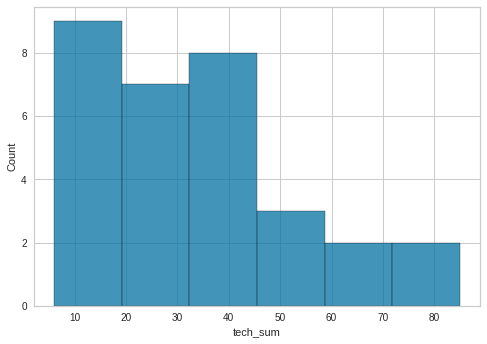

In [24]:
sum_province=pd.DataFrame()
sum_province["tech_sum"] = df_clustering_province.sum(axis=1)
sns.histplot(data=sum_province, x="tech_sum")

#### 5.2 | Geographical Distribution of EPP Patent dataset

The number of patents of EPP in all provinces or cities was counted. The top 15 provinces or cities are shown. Guangdong has the most significant number of patents, and Beijing is the second one.

<AxesSubplot:xlabel='Province/Cities'>

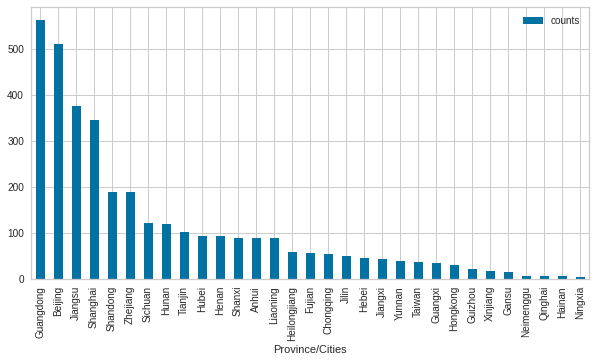

In [25]:
#caculate the number of each degree

num={} #dictionary
for i in df_region['Province/Cities']:
    if i not in num:
        num[i]=1
    else:
        num[i]=num[i]+1
        
#Ranking
num2=Counter(num).most_common() 

#change list into dataframe
num=dict(num2)
df_province_num= pd.DataFrame(num2,columns=['Province/Cities','counts'])
m=np.arange(11,31)
df_province_num.plot.bar(x ='Province/Cities', y = ['counts'], grid = True,figsize = (10,5))

In [26]:
# Get index positions of value in dataframe i.e. dfObj
def getIndexes(dfObj, value):
    listOfPos =list()
    # Get bool dataframe with True at positions where the given value exists
    result = dfObj.isin([value])
    # Get list of columns that contains the value
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    # Iterate over list of columns and fetch the rows indexes where value exists
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listOfPos.append((row))
    # Return a list of tuples indicating the positions of value in the dataframe
    return listOfPos

Among these provinces, Guangdong's number of patents in examination or valid and Beijing's number of patents in invalid are the most in the three categories, respectively.

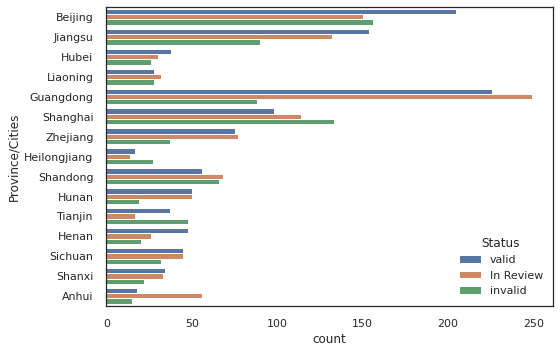

In [27]:
num=dict(num2)
sns.set_theme(style="white")

df_status= pd.DataFrame(df_region,columns=['Province/Cities','Status'])

k=['Fujian', 'Chongqing', 'Jilin', 'Hebei', 
   'Jiangxi', 'Yunnan', 'Taiwan', 
   'Guangxi', 'Hongkong', 'Guizhou',
   'Xinjiang', 'Gansu', 'Neimenggu', 
   'Qinghai', 'Hainan', 'Ningxia']

listOfPositions=list()
for i in range(len(k)):
    listOfPositions.append(getIndexes(df_status,k[i]))

for i in range(len(listOfPositions)):
    for m in range(len(listOfPositions[i])):
        df_status.drop(index=listOfPositions[i][m],inplace= True)
ax = sns.countplot(y="Province/Cities", hue="Status", data=df_status)

***

## 6.0 | Analysis

#### **6.1 | Dectecting EPP Patents**

The first part of the analysis will be building up a predictive model by using the training dataset we got from Google bigquery. This model will try to identify the EPP patents (test set) from enterprises related to (or non-related to) the epidemic prevention products industry. The test sets will not contain the patent used before.

**6.1.1 | Split the Dataset**

In [28]:
# split data 65%-35% into training set and test set

features_train, features_test, labels_train, labels_test = train_test_split(df_training_set_finished['text'].values,
                                                                            df_training_set_finished['Label'].values, test_size=0.35)

In [29]:
features_train.shape

(1028,)

In [30]:
features_test.shape

(554,)

**6.1.2 | Convert the Features of Patents to TFIDF**

In [31]:
words_transform_pipe = Pipeline( [('vect', CountVectorizer(stop_words='english')),   #convert the text into word counts in the pipeline
     ('tfidf',TfidfTransformer())]).fit(features_train)                              #use a TF-IDF transformer to convert the word counts to TFIDF

In [32]:
words_transform_result=words_transform_pipe.transform(features_train)

In [33]:
words_transform_pipe['tfidf'].idf_.shape

(9424,)

**6.1.3 | Prepare Grid Search**

We have already got the training dataset. The next step is to set the parameters. To get the best parameters, we use grid search.

In [34]:
#Grid sweep parameters to use the SGDClassifier
parameters = {
    'loss': ['log'],
    'penalty': ['none', 'l2', 'l1', 'elasticnet'],
    'alpha': [0.0001,0.001, 0.01, 0.1,1],
    'learning_rate': ['constant','optimal','invscaling'],
    'eta0':[.5,1],
    'class_weight': ['balanced', None]
}

#Grid search will find the best combination of parameters to use in  ML model
grid_search = GridSearchCV(SGDClassifier(), parameters)

The pipeline will contain three parts: countvectorizer,TF-IDF, grid search.

In [35]:
searching_clf = Pipeline( [('clf',grid_search)])  

**6.1.4 | Search the Best Parameters**

In [36]:
#Fit the data
print("Grid Searching")
searching_clf.fit(words_transform_result, labels_train)

Grid Searching


Pipeline(steps=[('clf',
                 GridSearchCV(estimator=SGDClassifier(),
                              param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1,
                                                    1],
                                          'class_weight': ['balanced', None],
                                          'eta0': [0.5, 1],
                                          'learning_rate': ['constant',
                                                            'optimal',
                                                            'invscaling'],
                                          'loss': ['log'],
                                          'penalty': ['none', 'l2', 'l1',
                                                      'elasticnet']}))])

In [37]:
print("The best score is:", grid_search.best_score_)

print( "The best parameter's values are:" )
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print ("\t%s: %r" % (param_name, best_parameters[param_name]))

The best score is: 0.9941510774331045
The best parameter's values are:
	alpha: 0.0001
	class_weight: 'balanced'
	eta0: 0.5
	learning_rate: 'constant'
	loss: 'log'
	penalty: 'none'


**We could also do a validation curve to detect the effectiveness of parameters. Here we take alpha as an example.**

In [38]:
alpha = [0.0001,0.001, 0.01, 0.1]
train_scores, valid_scores = validation_curve(estimator=SGDClassifier(), 
                                              X=words_transform_result, y=labels_train, 
                                              param_name="alpha",
                                              param_range=alpha,
                                              cv=5)

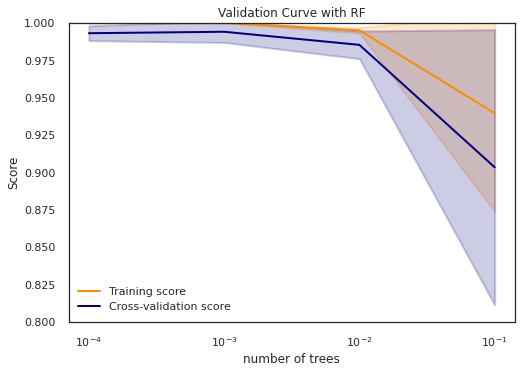

In [39]:
# plotting the validation curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.title("Validation Curve with RF")
plt.xlabel(r"number of trees")
plt.ylabel("Score")
plt.ylim(0.8, 1.0)
lw = 2
plt.semilogx(alpha, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(alpha, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(alpha, valid_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(alpha, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

**6.1.5 | Use Validation Dataset to Exam the Score of Predefined Model**

In [40]:
#grab the best estimator from the grid search
estimator = grid_search.best_estimator_

#create a reuseable pipepline to do the predictions
final_pipeline = Pipeline( [('vect', CountVectorizer(stop_words='english')),
     ('tfidf',TfidfTransformer()),
     ('estimator', estimator)])

final_pipeline.fit(features_train, labels_train)

accuracy = final_pipeline.score(features_test, labels_test)
print("Accuracy: ", accuracy)

# do a cross val score
score = cross_val_score(final_pipeline, features_test, labels_test)
print("cross val score:", score)

Accuracy:  0.9873646209386282
cross val score: [0.96396396 0.94594595 0.96396396 1.         0.99090909]


Confusion Matrix:
	  Pred True 	 Pred False
EPP True: 278 		 0
EPP False: 7 		 269
False Negatives: 0
False Positives: 7


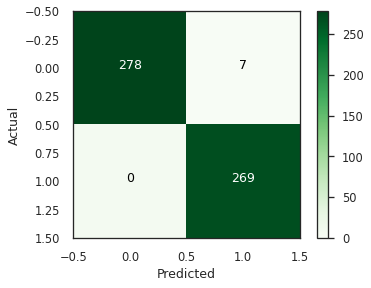

In [41]:
# plot confusion matrix
labels_predicted = final_pipeline.predict(features_test)
cm = confusion_matrix(labels_test, labels_predicted)

# print in text format
print("Confusion Matrix:\n\t", " Pred True \t Pred False")
print
print("EPP True:", cm[0][0], "\t\t", cm[0][1])
print("EPP False:", cm[1][0], "\t\t", cm[1][1])
print("False Negatives:", cm[0][1])
print("False Positives:", cm[1][0])

# plot confusion matrix with matplotlib.

fig = plt.figure(figsize=(6, 4), dpi=75)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Greens)
plt.colorbar()

plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.text(0, 0, str(cm[0][0]), color='white', fontsize=12, horizontalalignment='center')
plt.text(1, 0, str(cm[1][0]), color='black', fontsize=12, horizontalalignment='center')
plt.text(0, 1, str(cm[0][1]), color='black', fontsize=12, horizontalalignment='center')
plt.text(1, 1, str(cm[1][1]), color='white', fontsize=12, horizontalalignment='center')

plt.show()

**6.1.6 | Exam the Effectiveness of Predicted Model by Using External Patent Datasets**

We pull patent applications where the harmonized assignee is GILEAD SCIENCES INC on the face of the patent. The query creates the exact text as above, but this time we will use it for prediction instead of training.

In [42]:
assignee = "GILEAD SCIENCES INC%"

query = """
select pubs.publication_number, --pubs.assignee_harmonized,
      (SELECT text from UNNEST(pubs.title_localized)) as title,
        CONCAT(
        IFNULL(
         (SELECT text from UNNEST(pubs.title_localized)LIMIT 1), " "), " ",
        IFNULL(
         (SELECT text from UNNEST(pubs.abstract_localized) LIMIT 1), " "), " ",
        IFNULL(
         ARRAY_TO_STRING( ARRAY(SELECT code from UNNEST(pubs.ipc)LIMIT 1), " "), " " ), " ",
        IFNULL(
         ARRAY_TO_STRING( ARRAY(SELECT REGEXP_REPLACE( code, "/.*", "") from UNNEST(pubs.ipc)LIMIT 1), " "), " ")) as text
from
  `patents-public-data.patents.publications` as pubs, UNNEST(title_localized) as title
where 
country_code = 'US' and  --US only
application_kind = 'A' and --patents only
publication_date > 20000000 and  --The patents table uses a very awkward date formulation.  This queries for patents published after Jan 1, 2000.
EXISTS( SELECT 1 name from UNNEST(assignee_harmonized) where name LIKE '"""+ assignee + """')"""

df_target = pd.read_gbq(query, project_id=PROJECT_ID, dialect='standard')

print(df_target.shape)

(1403, 3)


Use the pipeline and run the predictions. Using **predict_proba** gives us the probabilty.

In [43]:
predictions = final_pipeline.predict_proba(df_target.text.values)

df_target['EPP_Predictions'] = [j for i,j in predictions]

In [44]:
#top 20 patents GILEAD SCIENCES INC owns that might be relevant to EPP:
df_display = df_target.nlargest(20, 'EPP_Predictions').sort_values('EPP_Predictions', ascending=False)

#make columns wrap instead of truncate:
pd.set_option('display.max_colwidth', None)
#drop the text column on display so it doesn't clutter everything, then display
display(df_display.drop("text", axis=1).head())

,publication_number,title,EPP_Predictions
874,US-7579332-B2,Nucleobase phosphonate analogs for antiviral treatment,0.998473
603,US-8809330-B2,"Pyrazolo[1,5-A]pyrimidines for antiviral treatment",0.998253
110,US-7737162-B2,Viral inhibitors,0.998052
652,US-2020030327-A1,Anti-hiv compounds,0.997949
108,US-9278975-B2,"Pyrazolo[1,5-A]pyrimidines as antiviral agents",0.997880


The examing results indicate that the prediction model we built could detect EPP patents. Here this example uses  **GILEAD SCIENCES INC**, which belongs to the medical industry. Thus, changing the enterprise to another and looking at how the score **(predict_proba)** changes could be done in the future.

#### 6.2 | Clustering Cities and Provinces

**6.2.1 | Calculate Multidimentional Reduction**

This def show how the Multidimentional Reduction is calculated.

In [45]:
def calculate_distance_matrix(x):
    d=metrics.pairwise_distances(x)
    return d
 
def cal_B(D):
    (n1,n2)=D.shape
    DD=np.square(D)
    Di=np.sum(DD,axis=1)/n1
    Dj=np.sum(DD,axis=0)/n1
    Dij=np.sum(DD)/(n1**2)
    B=np.zeros((n1,n1))
    for i in range(n1):
        for j in range(n2):
            B[i,j]=(Dij+DD[i,j]-Di[i]-Dj[j])/(-2)
    return B   
 
def MDS(data,n=2):
    D=calculate_distance_matrix(data)
    B=cal_B(D)
    Be,Bv=np.linalg.eigh(B)
    Be_sort=np.argsort(-Be)
    Be=Be[Be_sort]
    Bv=Bv[:,Be_sort]
    Bez=np.diag(Be[0:n])
    Bvz=Bv[:,0:n]
    Z=np.dot(np.sqrt(Bez),Bvz.T).T
    return Z

We calculate the MDS for two level: city and province.

In [46]:
Z=MDS(df_clustering_city)
Z2=MDS(df_clustering_province)

**6.2.2 | Clustering**

The whole parts of clustering algorithms were integrated into this def. The results will be shown in four graphs. The first one shows how the data distributed in a 2-D dimension. The second and third graphs will show the results of the K value tests. The last one is the K-Means result of using the best k value.

In [47]:
def clustering(data,col):
    MDSresult=pd.DataFrame(data, columns=['X','Y']) 
    model = sk_cluster.KMeans()
    p_tests=["distortion","silhouette"]
    k_values = []
    k_values_score = []
    
    # Visualise the points.
    fig, ax = plt.subplots()
    plt.scatter(x=MDSresult['X'], y=MDSresult['Y'], label='Observations',s=14,c='grey')
    plt.legend()
    plt.title(f"Graphical Results of {col} Projecting ")
    plt.xlabel('X')
    plt.ylabel('Y')
    
    # Visualise the test (distortion, silhouette) results.
    for index,test in enumerate(p_tests):
        fig, ax = plt.subplots()
        model_tests = KElbowVisualizer(model, metric = test)
        model_tests.fit(MDSresult)
        model_tests.show()
        k_values.append(model_tests.elbow_value_)
        k_values_score.append(model_tests.elbow_score_)
        
    # Visualise KMeans results
    fig, ax = plt.subplots()
    color_for_use=[]
    colorscheme = np.array(['red', 'blue','black','pink','yellow'])
    if k_values_score[0] > k_values_score[1]:    
        kmeans = KMeans(n_clusters=k_values[0])
        kmeans.fit(MDSresult)
        categories = kmeans.predict(MDSresult)
        for i in range(k_values[0]):
            color_for_use.append(colorscheme[i])
    else:
        kmeans = KMeans(n_clusters=k_values[1])
        kmeans.fit(MDSresult)
        categories = kmeans.predict(MDSresult)
        for i in range(k_values[1]):
            color_for_use.append(colorscheme[i])
    
    colormap=np.array(color_for_use)
        
    plt.scatter(x=MDSresult['X'], y=MDSresult['Y'], c=colormap[categories], s=10, cmap='viridis')
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.4);
    plt.title(f"Graphical Results of {col} Clustering ")
    plt.xlabel('X')
    plt.ylabel('Y')
    return categories

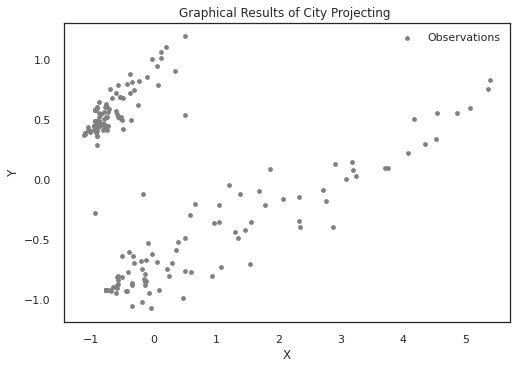

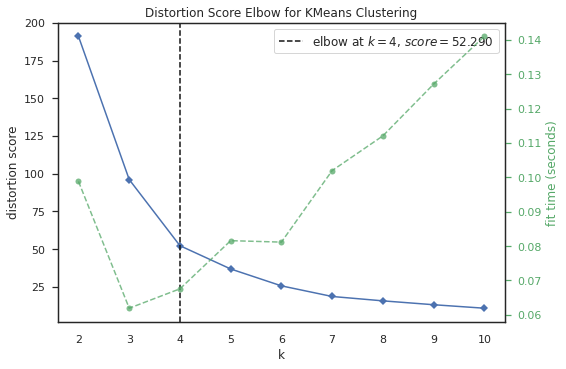

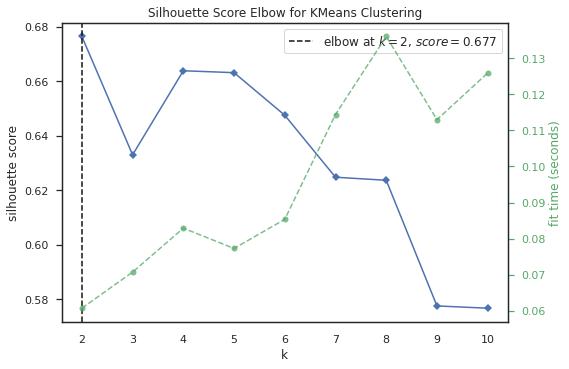

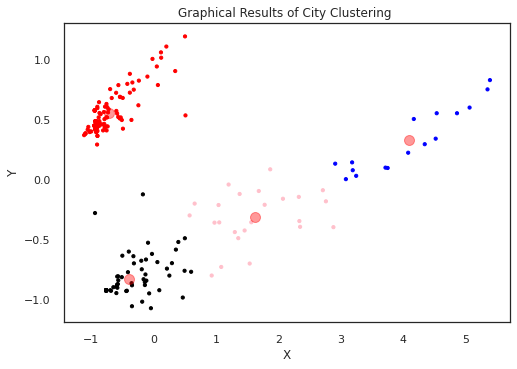

In [48]:
categories= clustering(Z,'City')

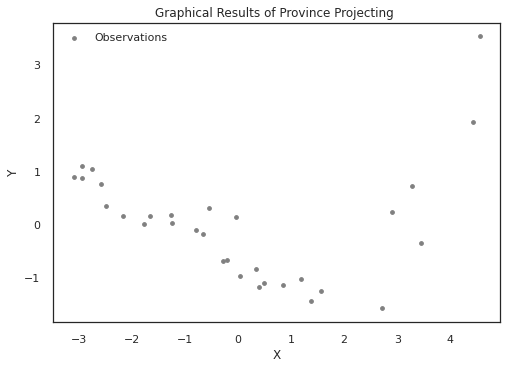

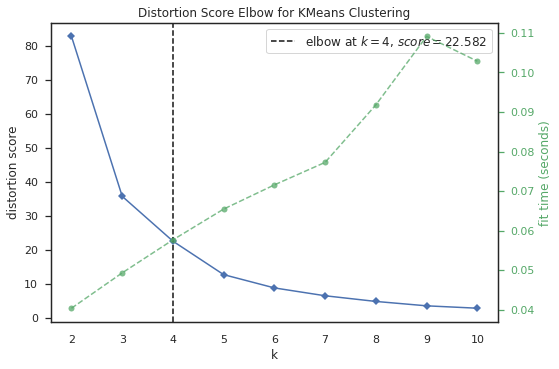

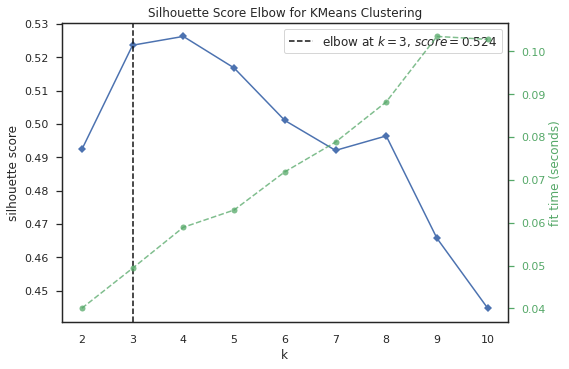

array([0, 2, 0, 0, 1, 3, 0, 1, 1, 1, 0, 0, 0, 0, 1, 3, 1, 0, 0, 1, 1, 1,
       2, 2, 0, 0, 0, 0, 1, 1, 2], dtype=int32)

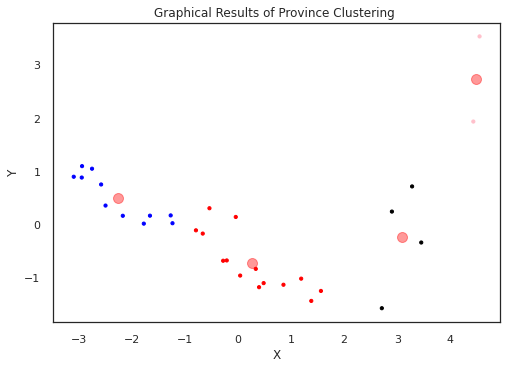

In [49]:
clustering(Z2,'Province')

The result of clustering for province performs not well relatively. This may because the samples of this level are relatively small.

**6.2.3 | Extract Information of each Cities' Clusters**

Here we extract the cluster information of cities to look at how cities aggregated.

In [50]:
def cluster_tech(p_df_clustering_city,p_category):
    citycluster=pd.DataFrame()
    citycluster['cluster']=p_category
    df_clustering_resetindex=p_df_clustering_city.reset_index()
    df_clustering_cityresult=pd.concat([df_clustering_resetindex, citycluster], axis=1)
    d=[]
    cluster_tech_display=[]
    for i in range(4):
        d.append(df_clustering_cityresult[df_clustering_cityresult['cluster'] == i])
        drop_col=['cluster']
        for index, entry in enumerate(drop_col):
            d[i]=d[i].drop(drop_col[index], axis=1)
        d[i]=d[i].T 
        d[i].columns = d[i].iloc[0]
        d[i] = d[i].iloc[1:]
        d[i]['Col_sum'] = d[i].apply(lambda x: x.sum (), axis = 1)

        cluster_tech_display.append(d[i].nlargest(10, 'Col_sum').sort_values('Col_sum', ascending=False)) # only return top 10 technologies.
        cluster_tech_display[i]=cluster_tech_display[i].reset_index()
        cluster_tech_display[i].columns.names = ['id']
        cluster_tech_display[i]=cluster_tech_display[i].rename(columns={'index': 'IPC'})
        
    return cluster_tech_display[0],cluster_tech_display[1],cluster_tech_display[2],cluster_tech_display[3]

In [51]:
cluster1_tech,cluster2_tech,cluster3_tech,cluster4_tech = cluster_tech(df_clustering_city,categories)

In [52]:
cluster1_tech.columns

Index(['IPC', 'Akesu', 'Anshan', 'Anyang', 'Baise', 'Baiying', 'Bangbu',
       'Baoji', 'Baotou', 'Binzhou',
       ...
       'Zhaoyuan', 'Zhongwei', 'Zhoushan', 'Zhuji', 'Zhuzhou', 'Zibo',
       'Zigong', 'Zoucheng', 'Zunyi', 'Col_sum'],
      dtype='object', name='id', length=110)

In [53]:
cluster1_tech['IPC']

0    A61H
1    A61B
2    B25J
3    A41D
4    C02F
5    G06F
6    A61L
7    A61G
8    A61F
9    G16H
Name: IPC, dtype: object

In [54]:
cluster2_tech.columns

Index(['IPC', 'Beijing', 'Chengdu', 'Chongqing', 'Guangzhou', 'Hangzhou',
       'Hefei', 'Jinan', 'Nanjing', 'Qingdao', 'Shanghai', 'Shenzhen',
       'Suzhou', 'Tianjin', 'Wuhan', 'Xi'an', 'Zhengzhou', 'Col_sum'],
      dtype='object', name='id')

In [55]:
cluster2_tech['IPC']

0    A61K
1    A61P
2    C12Q
3    C12N
4    G06F
5    A61H
6    A61L
7    G01N
8    A61B
9    G06T
Name: IPC, dtype: object

In [56]:
cluster3_tech.columns

Index(['IPC', 'Aba', 'Anguo', 'Ankang', 'Baoding', 'Bozhou', 'Chifeng',
       'Daqing', 'Dunhua', 'Feixian', 'Fushun', 'Fuyang', 'Ganzhou', 'Guigang',
       'Guilin', 'Haikou', 'Hegang', 'Heihe', 'Hengyang', 'Heze', 'Huludao',
       'Huzhou', 'Ji'an', 'Jiangmen', 'Jiangyan', 'Jieyang', 'Jingzhou',
       'Jinhua', 'Jixi', 'Langfang', 'Lanxi', 'Lianyungang', 'Linyi', 'Lishui',
       'Luohe', 'Meihekou', 'Nanchang', 'Nanning', 'Ningde', 'Pingdingshan',
       'Qiannan', 'Rizhao', 'Shangrao', 'Shaoguan', 'Shaoxing', 'Shijiazhuang',
       'Shiyan', 'Siping', 'Suihua', 'Taizhong', 'Tangshan', 'Tianshui',
       'Tonghua', 'Tongliao', 'Urumchi', 'Xiangyang', 'Xining', 'Xuchang',
       'Xuzhou', 'Ya'an', 'Yantai', 'Yichang', 'Yinchuan', 'Yiwu', 'Yongzhou',
       'Yueyang', 'Yuncheng', 'Yunfu', 'Zaozhuang', 'Zhangzhou', 'Zhaoqing',
       'Zhuhai', 'Col_sum'],
      dtype='object', name='id')

In [57]:
cluster3_tech['IPC']

0    A61K
1    A61P
2    A61H
3    G06F
4    C12Q
5    C07D
6    G16H
7    C12N
8    G01N
9    A61B
Name: IPC, dtype: object

In [58]:
cluster4_tech.columns

Index(['IPC', 'Changchun', 'Changsha', 'Dalian', 'Dongguan', 'Foshan',
       'Fuzhou', 'Guiyang', 'Harbin', 'Kunming', 'Lanzhou', 'Liuzhou',
       'Luoyang', 'Nantong', 'Ningbo', 'Shenyang', 'Taibei', 'Taizhou',
       'Weifang', 'Wuhu', 'Wuxi', 'Xiamen', 'Yangzhou', 'Zhenjiang',
       'Zhongshan', 'Col_sum'],
      dtype='object', name='id')

In [59]:
cluster4_tech['IPC']

0    A61K
1    A61P
2    G16H
3    A61B
4    A61H
5    G06F
6    C02F
7    A61L
8    G06Q
9    C12Q
Name: IPC, dtype: object

**The form is the descriptions of IPCs shown above.**

|IPC | Description                                                                                                | Notes                                                    |
|----|------------------------------------------------------------------------------------------------------------|----------------------------------------------------------|
|A41D| OUTERWEAR;PROTECTIVE GARMENTS;ACCESSORIES                                                                  |                                                          |
|A61B| DIAGNOSIS;SURGERY; IDENTIFICATION                                                                          | analysing biological material G01N, e.g. G01N 33/48      |
|A61F| FILTERS IMPLANTABLE INTO BLOOD VESSELS; PROSTHESES; DEVICES PROVIDING PATENCY TO, OR PREVENTING COLLAPSING OF, TUBULAR STRUCTURES OF THE BODY, e.g. STENTS; ORTHOPAEDIC, NURSING OR CONTRACEPTIVE DEVICES; FOMENTATION; TREATMENT OR PROTECTION OF EYES OR EARS; BANDAGES, DRESSINGS OR ABSORBENT PADS; FIRST-AID KITS                                                                                                                                       |dental prosthetics A61C                                   |
|A61G| TRANSPORT, PERSONAL CONVEYANCES, OR ACCOMMODATION SPECIALLY ADAPTED FOR PATIENTS OR DISABLED PERSONS; OPERATING TABLES OR CHAIRS; CHAIRS FOR DENTISTRY; FUNERAL DEVICES                                                                                                                   |appliances for aiding patients or disabled persons to walk A61H 3/00;embalming corpses A01N 1/00                                                                                                                                        |
|A61H| PHYSICAL THERAPY APPARATUS, e.g. DEVICES FOR LOCATING OR STIMULATING REFLEX POINTS IN THE BODY; ARTIFICIAL RESPIRATION; MASSAGE; BATHING DEVICES FOR SPECIAL THERAPEUTIC OR HYGIENIC PURPOSES OR SPECIFIC PARTS OF THE BODY                                                    | electrotherapy, magnetotherapy, radiation therapy, ultrasound therapy A61N                                                                                                                                                      |
|A61K|PREPARATIONS FOR MEDICAL, DENTAL, OR TOILET PURPOSES                                                        | devices or methods specially adapted for bringing pharmaceutical products into particular physical or administering forms A61J 3/00; chemical aspects of, or use of materials for deodorisation of air, for disinfection or sterilisation, or for bandages, dressings, absorbent pads or surgical articles A61L; soap compositions C11D                                                                  |
|A61L|METHODS OR APPARATUS FOR STERILISING MATERIALS OR OBJECTS IN GENERAL; DISINFECTION, STERILISATION, OR DEODORISATION OF AIR; CHEMICAL ASPECTS OF BANDAGES, DRESSINGS, ABSORBENT PADS, OR SURGICAL ARTICLES; MATERIALS FOR BANDAGES, DRESSINGS, ABSORBENT PADS, OR SURGICAL ARTICLES     |preservation of bodies or disinfecting characterised by the agent employed A01N; preserving, e.g. sterilising, food or foodstuffs A23; preparations for medical, dental or toilet purposes A61K                                          |
|A61P|SPECIFIC THERAPEUTIC ACTIVITY OF CHEMICAL COMPOUNDS OR MEDICINAL PREPARATIONS                               |                                                          |
|B25J|MANIPULATORS; CHAMBERS PROVIDED WITH MANIPULATION DEVICES                                                   |                                                          |
|C02F|TREATMENT OF WATER, WASTE WATER, SEWAGE, OR SLUDGE                                                          |                                                          |
|C07D|HETEROCYCLIC COMPOUNDS                                                                                      | macromolecular compounds C08                             |
|C12N|MICROORGANISMS OR ENZYMES; COMPOSITIONS THEREOF; PROPAGATING, PRESERVING, OR MAINTAINING MICROORGANISMS; MUTATION OR GENETIC ENGINEERING; CULTURE MEDIA                                                                                                                                   | microbiological testing media C12Q 1/00                  |
|C12Q|MEASURING OR TESTING PROCESSES INVOLVING ENZYMES, NUCLEIC ACIDS OR MICROORGANISMS ; COMPOSITIONS OR TEST PAPERS THEREFOR; PROCESSES OF PREPARING SUCH COMPOSITIONS; CONDITION-RESPONSIVE CONTROL IN MICROBIOLOGICAL OR ENZYMOLOGICAL PROCESSES                                        | immunoassay G01N 33/53                                   |
|G01N|INVESTIGATING OR ANALYSING MATERIALS BY DETERMINING THEIR CHEMICAL OR PHYSICAL PROPERTIES                   |measuring or testing processes other than immunoassay, involving enzymes or microorganisms C12M, C12Q                                                                                                                               |
|G06F|ELECTRIC DIGITAL DATA PROCESSING                                                                            |computer systems based on specific computational models G06N                                                                                                                                                                         |
|G06Q|DATA PROCESSING SYSTEMS OR METHODS, SPECIALLY ADAPTED FOR ADMINISTRATIVE, COMMERCIAL, FINANCIAL, MANAGERIAL, SUPERVISORY OR FORECASTING PURPOSES; SYSTEMS OR METHODS SPECIALLY ADAPTED FOR ADMINISTRATIVE, COMMERCIAL, FINANCIAL, MANAGERIAL, SUPERVISORY OR FORECASTING PURPOSES, NOT OTHERWISE PROVIDED FOR                                                                                                                                                         |                                                          |
|G06T|IMAGE DATA PROCESSING OR GENERATION, IN GENERAL                                                             |                                                          |
|G16H|HEALTHCARE INFORMATICS, i.e. INFORMATION AND COMMUNICATION TECHNOLOGY (ICT) SPECIALLY ADAPTED FOR THE HANDLING OR PROCESSING OF MEDICAL OR HEALTHCARE DATA                                                                                                                                 |                                                          |

***

## 7.0 | Discussion and Conclusion

In conclusion, this paper looks deep into China's EPP patents spatial distribution and the main technologies embedded in patents and tries to find technologies clusters at the city and province level. A prediction model for detecting EPP patents was trained, validated and tested. These works are finished to answer these questions:
         
    RQ1 | How do China's cities aggregated when considering various types of technologies embedded in EPP patents they own?
    RQ2 | How could a EPP patent prediction model be built by using Machine Learning on patent documents? How accurate is this model's prediction?
    RQ3 | Is there any clustering diversity when two different space scale are implemented?

China's cities could be clustering into four groups when considering the types of EPP technologies they own. Unlike other groups, one group of cities show their strength on A61H and A61B, which refers to PHYSICAL THERAPY APPARATUS and DIAGNOSIS; SURGERY; IDENTIFICATION. This group contains Akesu, Baise, Baiying, Bangbu, Baoji, Baotou, Binzhou, etc. Most cities in these group own a small amount of EPP technologies resources relatively. Another group's cities are also easily distinguished, and it contains Beijing, Chengdu, Chongqing, Guangzhou, Hangzhou, Hefei, Jinan, Nanjing, Qingdao, Shanghai, Shenzhen, etc. This group of cities cover almost all types of technologies shown in the EPP dataset, and the strength of EPP patents production is much higher than any other groups of cities. The other two groups of cities focus on A61K and A61P. one of the two groups contains Changchun, Changsha, Dalian, Dongguan, Foshan, Fuzhou, Guiyang, Harbin, Kunming, Lanzhou, Liuzhou, Luoyang, Nantong, Ningbo, Shenyang, Taibei, etc. Most of the cities in this group are central cities in their region or urban agglomeration. The last one also owns a small amount of EPP technologies resources. The results show that the hierarchical system of EPP patent technologies has been embedded since 1995 when the first EPP patent was published in China.

As for differences of clustering in two different spatial scale, the result of province level is not well, which may cause by the size of the sample. The distribution of each province is relatively more scattered compared to the city level. The score of distortion and silhouette are both low when doing K-Means clustering. In the future, the spatial scale of the study can be reduced to district level or further. 

The results from applying machine learning show that the prediction model could detect the EPP patents. The confusion matrix, cross Val score, and accuracy show that the model has a relatively good accurate identification ability. However, in the future, detecting more specific patents (EPP is a massive collection of various patents) based on their technologies could be more valuable.

***

## Bibliography

AMIN, A. and THRIFT, N. (1992) ‘Neo‐Marshallian Nodes in Global Networks’, International Journal of Urban and Regional Research, 16(4), pp. 571–587. doi: 10.1111/j.1468-2427.1992.tb00197.x.

Asheim, B., Coenen, L. and Vang, J. (2007) ‘Face-to-Face, Buzz, and Knowledge Bases: Sociospatial Implications for Learning, Innovation, and Innovation Policy’, Environment and Planning C: Government and Policy, 25(5), pp. 655–670. doi: 10.1068/c0648.

Aydalot, P. and Keeble, D. (1988) High technology industry and innovative environments : the European experience / edited by Philippe Aydalot and David Keeble. Edited by P. Aydalot et al. London: Routledge.

Bagchi-Sen, S., Smith, H. L. and Hall, L. (2004) ‘The US biotechnology industry: Industry dynamics and policy’, Environment and Planning C: Government and Policy, 22(2), pp. 199–216. doi: 10.1068/c0345.

Coenen, L., Moodysson, J. and Asheim, B. T. (2004) ‘Nodes, networks and proximities: on the knowledge dynamics of the Medicon Valley biotech cluster’, European planning studies, 12(7), pp. 1003–1018. doi: 10.1080/0965431042000267876.

Cooke, P. (1992) ‘Regional innovation systems: Competitive regulation in the new Europe’, Geoforum, 23(3), pp. 365–382. doi: 10.1016/0016-7185(92)90048-9.

Das, K. (1998) ‘Collective dynamism and firm strategy: Study of an indian industrial cluster’, Entrepreneurship and Regional Development, 10(1). doi: 10.1080/08985629800000003.

Georghiou, L. (1993) ‘ National Systems of Innovation. Towards a Theory of Innovation and Interactive Learning edited by Bengt-Ake Lundvall (Pinter Publishers, London. 1992) pp. xiii + 342, £45, ISBN 1-85567-063-1 ’, Prometheus, 11(2), pp. 291–291. doi: 10.1080/08109029308629360.

Granovetter, M. (1985) ‘Economic Action and Social Structure: The Problem of Embeddedness’, American Journal of Sociology, 91(3), pp. 481–510. doi: 10.1086/228311.

Jun, S., Park, S. S. and Jang, D. S. (2012) ‘Patent Management for Technology Forecasting: A Case study of the bio-industry’, Journal of Intellectual Property Rights, 17(6).

Jun, S. (2016) ‘Time series clustering model based on complexity for apple technology forecasting’, International Journal of Applied Engineering Research, 11(20), pp. 10343–10347.

Kim, G. and Bae, J. (2017) ‘A novel approach to forecast promising technology through patent analysis’, Technological Forecasting and Social Change, 117, pp. 228–237. doi: 10.1016/j.techfore.2016.11.023.

Park, Y., Yoon, B. and Lee, S. (2005) ‘The idiosyncrasy and dynamism of technological innovation across industries: Patent citation analysis’, Technology in Society, 27(4), pp. 471–485. doi: 10.1016/j.techsoc.2005.08.003.

Plum, O. and Hassink, R. (2011) ‘Comparing knowledge networking in different knowledge bases in Germany’, Papers in regional science, 90(2), pp. 355–371. doi: 10.1111/j.1435-5957.2011.00362.x.

Shih, M. J., Liu, D. R. and Hsu, M. L. (2010) ‘Discovering competitive intelligence by mining changes in patent trends’, Expert Systems with Applications, 37(4), pp. 2882–2890. doi: 10.1016/j.eswa.2009.09.001.

***

## Appendix

The original data used in this notebook could be found [here](https://ncp.patentstar.cn/).

The machine learning codes used in this notebook largely based on this [notebook](https://github.com/DeltaCharlieAlpha/PatentAnalysisNotebooks/blob/master/PatentAnalysisExample.ipynb).The author is  [DeltaCharlieAlpha](https://github.com/DeltaCharlieAlpha).